In [1]:
pwd

'/Users/sachinmishra/Desktop/LangGraph_Project_Based_Learning/All_Experiment'

In [2]:
from langchain_openai import AzureOpenAIEmbeddings

import os
from dotenv import load_dotenv

# Load environment variables
load_dotenv(override=True)

def get_azure_embedding_model():
    return AzureOpenAIEmbeddings(
        azure_deployment=os.getenv("AZURE_OPENAI_EMBEDDING_DEPLOYMENT"),
        azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
        api_key=os.getenv("AZURE_OPENAI_API_KEY"),
        api_version=os.getenv("AZURE_OPENAI_API_VERSION"),
    )

In [3]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings
def get_gemini_embedding_model():
    return GoogleGenerativeAIEmbeddings(model="models/gemini-embedding-001")

In [4]:
from langchain_community.vectorstores import FAISS

def get_vectorstore():
    """Load the FAISS vector store."""
   
    # Load environment variables
    load_dotenv(override=True)

    # Load embeddings
    #embeddings = get_azure_embedding_model()
    embeddings = get_gemini_embedding_model()

    # === Load FAISS index ===
    faiss_path = r"/Users/sachinmishra/Desktop/LangGraph_Project_Based_Learning/faiss_index_financial"
    vectorstore = FAISS.load_local(
        faiss_path,
        embeddings=embeddings,  # not required for searching
        allow_dangerous_deserialization=True
    )
    
    return vectorstore

In [5]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import BaseMessage, HumanMessage

def get_groq_llm():
    return ChatOpenAI(
        model="openai/gpt-oss-20b",  # or another Groq model you have access to
        base_url="https://api.groq.com/openai/v1",
        api_key=os.getenv("GROQ_API_KEY"),
        temperature=0.2,
        max_tokens=2500,
    )

In [6]:
from dotenv import load_dotenv

load_dotenv(override=True)
#embeddings = get_azure_embedding_model()
embeddings = get_gemini_embedding_model()
vectorstore = get_vectorstore()

search_kwargs = {"k": 3}
roles = ["analyst"]  # Example roles to filter by
if roles:
    # FAISS supports $in filter for metadata
    search_kwargs["filter"] = {"role": {"$in": roles}}

retriever = vectorstore.as_retriever(search_kwargs=search_kwargs)


In [7]:
from langchain_core.prompts import ChatPromptTemplate

llm = get_groq_llm()

template = """Answer the question based on the following context and the Chathistory. Especially take the latest question into consideration:

Chathistory: {history}

Context: {context}

Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)
rag_chain = prompt | llm

In [8]:
off_topic_llm = get_groq_llm()

template = """
When a user asks an off-topic question (not related to JPM 2023 pdf/report or JPM SE Annual report/pdf ):

Provide a short, polite answer to acknowledge their query.

Immediately and firmly remind the user that you are built specifically for finance-related queries.

Encourage them to return to finance-related questions, since that’s where you can provide real value.

If relevant, use the chat history to make your reminder more natural and connected to past discussions.

Always maintain a friendly but professional tone.

chat_history: {history}

Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)
off_topic_rag_chain = prompt | off_topic_llm

In [9]:
from langchain_community.utilities import SerpAPIWrapper

In [10]:
from typing import TypedDict, List
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage
from langchain_core.documents import Document
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate
from langgraph.graph import StateGraph, END


class AgentState(TypedDict):
    messages: List[BaseMessage]
    documents: List[Document]
    on_topic: str
    rephrased_question: str
    proceed_to_generate: bool
    rephrase_count: int
    question: HumanMessage


class GradeQuestion(BaseModel):
    score: str = Field(
        description="Question is about the specified topics? If yes -> 'Yes' if not -> 'No'"
    )


def question_rewriter(state: AgentState):
    print(f"Entering question_rewriter with following state: {state}")

    # Reset state variables except for 'question' and 'messages'
    state["documents"] = []
    state["on_topic"] = ""
    state["rephrased_question"] = ""
    state["proceed_to_generate"] = False
    state["rephrase_count"] = 0

    if "messages" not in state or state["messages"] is None:
        state["messages"] = []

    if state["question"] not in state["messages"]:
        state["messages"].append(state["question"])

    if len(state["messages"]) > 1:
        conversation = state["messages"][:-1]
        current_question = state["question"].content
        messages = [
            SystemMessage(
                content="You are a helpful assistant that rephrases the user's question to be a standalone question optimized for retrieval."
            )
        ]
        messages.extend(conversation)
        messages.append(HumanMessage(content=current_question))
        rephrase_prompt = ChatPromptTemplate.from_messages(messages)
        llm = get_groq_llm()
        prompt = rephrase_prompt.format()
        response = llm.invoke(prompt)
        better_question = response.content.strip()
        print(f"question_rewriter: Rephrased question: {better_question}")
        state["rephrased_question"] = better_question
    else:
        state["rephrased_question"] = state["question"].content
    return state

def question_classifier(state: AgentState):
    print("Entering question_classifier")
    system_message = SystemMessage(
        content=""" You are a classifier that determines whether a user's question is about one of the following Financial topics 
    
    
    1. About jp morgan chase & co and it's financial services/reports
    2. Any question related to stock market, investment, banking, finance, financial analysis, financial reports, financial services, economic trends, market analysis, investment strategies, financial planning, asset management, wealth management, corporate finance, personal finance, financial regulations, financial technology (fintech), or financial markets.
    
    If the question IS about any of these topics, respond with 'Yes'. Otherwise, respond with 'No'.

    """
    )

    human_message = HumanMessage(
        content=f"User question: {state['rephrased_question']}"
    )
    grade_prompt = ChatPromptTemplate.from_messages([system_message, human_message])
    llm = get_groq_llm()
    structured_llm = llm.with_structured_output(GradeQuestion)
    grader_llm = grade_prompt | structured_llm
    result = grader_llm.invoke({})
    state["on_topic"] = result.score.strip()
    print(f"question_classifier: on_topic = {state['on_topic']}")
    return state

def on_topic_router(state: AgentState):
    print("Entering on_topic_router")
    on_topic = state.get("on_topic", "").strip().lower()
    if on_topic == "yes":
        print("Routing to retrieve")
        return "retrieve"
    else:
        print("Routing to off_topic_response")
        return "off_topic_response"


def retrieve(state: AgentState):
    print("Entering retrieve")
    documents = retriever.invoke(state["rephrased_question"])
    print(f"retrieve: Retrieved {len(documents)} documents")
    state["documents"] = documents
    return state


class GradeDocument(BaseModel):
    score: str = Field(
        description="Document is relevant to the question? If yes -> 'Yes' if not -> 'No'"
    )

def retrieval_grader(state: AgentState):
    print("Entering retrieval_grader")
    system_message = SystemMessage(
        content="""You are a grader assessing the relevance of a retrieved document to a user question.
Only answer with 'Yes' or 'No'.

If the document contains information relevant to the user's question, respond with 'Yes'.
Otherwise, respond with 'No'."""
    )

    llm = get_groq_llm()
    structured_llm = llm.with_structured_output(GradeDocument)

    relevant_docs = []
    for doc in state["documents"]:
        human_message = HumanMessage(
            content=f"User question: {state['rephrased_question']}\n\nRetrieved document:\n{doc.page_content}"
        )
        grade_prompt = ChatPromptTemplate.from_messages([system_message, human_message])
        grader_llm = grade_prompt | structured_llm
        result = grader_llm.invoke({})
        print(
            f"Grading document: {doc.page_content[:30]}... Result: {result.score.strip()}"
        )
        if result.score.strip().lower() == "yes":
            relevant_docs.append(doc)
    state["documents"] = relevant_docs
    state["proceed_to_generate"] = len(relevant_docs) > 0
    print(f"retrieval_grader: proceed_to_generate = {state['proceed_to_generate']}")
    return state

def proceed_router(state: AgentState):
    print("Entering proceed_router")
    rephrase_count = state.get("rephrase_count", 0)
    if state.get("proceed_to_generate", False):
        print("Routing to generate_answer")
        return "generate_answer"
    elif rephrase_count >= 2:
        print("Maximum rephrase attempts reached. Cannot find relevant documents.")
        return "search_internet"
    else:
        print("Routing to refine_question")
        return "refine_question"
    
def refine_question(state: AgentState):
    print("Entering refine_question")
    rephrase_count = state.get("rephrase_count", 0)
    if rephrase_count >= 2:
        print("Maximum rephrase attempts reached")
        return state
    question_to_refine = state["rephrased_question"]
    system_message = SystemMessage(
        content="""You are a helpful JPM financial assistant that slightly refines the user's question to improve retrieval results.
Provide a slightly adjusted version of the question."""
    )
    human_message = HumanMessage(
        content=f"Original question: {question_to_refine}\n\nProvide a slightly refined question."
    )
    refine_prompt = ChatPromptTemplate.from_messages([system_message, human_message])
    llm = get_groq_llm()
    prompt = refine_prompt.format()
    response = llm.invoke(prompt)
    refined_question = response.content.strip()
    print(f"refine_question: Refined question: {refined_question}")
    state["rephrased_question"] = refined_question
    state["rephrase_count"] = rephrase_count + 1
    return state

def generate_answer(state: AgentState):
    print("Entering generate_answer")
    if "messages" not in state or state["messages"] is None:
        raise ValueError("State must include 'messages' before generating an answer.")

    history = state["messages"]
    documents = state["documents"]
    rephrased_question = state["rephrased_question"]

    response = rag_chain.invoke(
        {"history": history, "context": documents, "question": rephrased_question}
    )

    generation = response.content.strip()

    state["messages"].append(AIMessage(content=generation))
    print(f"generate_answer: Generated response: {generation}")
    return state

# def cannot_answer(state: AgentState):
#     print("Entering cannot_answer")
#     if "messages" not in state or state["messages"] is None:
#         state["messages"] = []
#     state["messages"].append(
#         AIMessage(
#             content="I'm sorry, but I cannot find the information you're looking for."
#         )
#     )
#     return state


def search_internet(state: AgentState):
    print("Entering search_internet")
    search = SerpAPIWrapper()
    if "messages" not in state or state["messages"] is None:
        raise ValueError("State must include 'messages' before generating an answer.")
    rephrased_question = state["rephrased_question"]
    
    search_results = search.run(rephrased_question)
    state["messages"].append(
        AIMessage(
            content=search_results
        )
    )
    print(f"search_internet: Search results: {search_results}")
    return state


def off_topic_response(state: AgentState):
    print("Entering off_topic_response")
    if "messages" not in state or state["messages"] is None:
        state["messages"] = []
    history = state["messages"]
    response= off_topic_rag_chain.invoke(
        {"history": history, "question": state['rephrased_question']}
    )
    final_answer = response.content.strip()
    state["messages"].append(AIMessage(content=final_answer))
    print(f"off_topic_response: Final answer: {final_answer}")
    return state

In [11]:
### In memory checkpointing (disabled for now)

# from langgraph.checkpoint.memory import MemorySaver

# checkpointer = MemorySaver()

In [12]:
from langgraph.checkpoint.sqlite import SqliteSaver
import sqlite3


In [13]:
sqlite_conn = sqlite3.connect("financebot_new.sqlite", check_same_thread=False)

checkpointer = SqliteSaver(sqlite_conn)


In [14]:
# Workflow
workflow = StateGraph(AgentState)
workflow.add_node("question_rewriter", question_rewriter)
workflow.add_node("question_classifier", question_classifier)
workflow.add_node("off_topic_response", off_topic_response)
workflow.add_node("retrieve", retrieve)
workflow.add_node("retrieval_grader", retrieval_grader)
workflow.add_node("generate_answer", generate_answer)
workflow.add_node("refine_question", refine_question)
#workflow.add_node("cannot_answer", cannot_answer)
workflow.add_node("search_internet", search_internet)

workflow.add_edge("question_rewriter", "question_classifier")
workflow.add_conditional_edges(
    "question_classifier",
    on_topic_router,
    {
        "retrieve": "retrieve",
        "off_topic_response": "off_topic_response",
    },
)
workflow.add_edge("retrieve", "retrieval_grader")
workflow.add_conditional_edges(
    "retrieval_grader",
    proceed_router,
    {
        "generate_answer": "generate_answer",
        "refine_question": "refine_question",
        "search_internet": "search_internet",
    },
)
workflow.add_edge("refine_question", "retrieve")
workflow.add_edge("generate_answer", END)
#workflow.add_edge("cannot_answer", "search_internet")
workflow.add_edge("search_internet", END)
workflow.add_edge("off_topic_response", END)
workflow.set_entry_point("question_rewriter")
graph = workflow.compile(checkpointer=checkpointer)

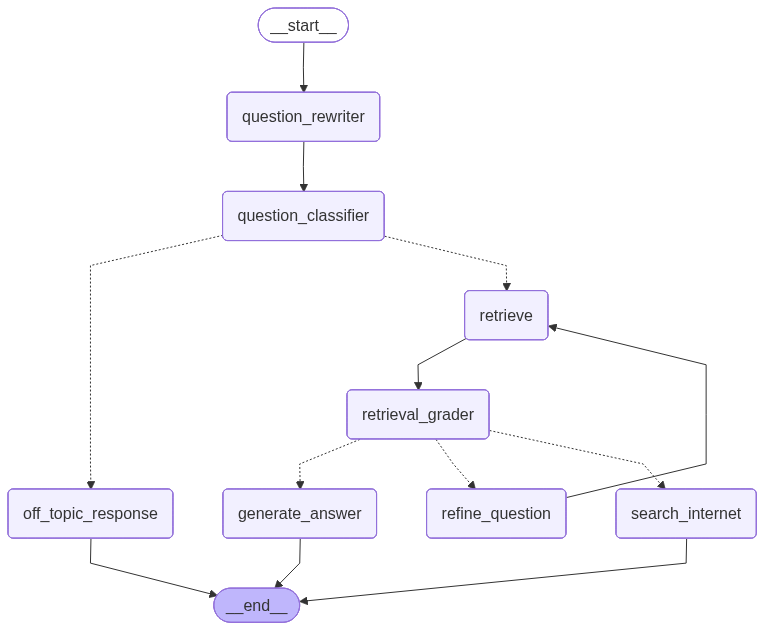

In [15]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [16]:
print(.)

SyntaxError: invalid syntax (1297590807.py, line 1)

Off Topic: 

In [ ]:
input_data = {"question": HumanMessage(content="What does the company Apple do?")}
graph.invoke(input=input_data, config={"configurable": {"thread_id": 1}})


Entering question_rewriter with following state: {'messages': [HumanMessage(content='What does the company Apple do?', additional_kwargs={}, response_metadata={}), AIMessage(content='Thanks for your question! I’m here to help with finance‑related topics. If you’d like to discuss Apple’s financial performance, valuation, or any other money‑related aspect, feel free to ask—happy to dive into the numbers with you.', additional_kwargs={}, response_metadata={})], 'documents': [], 'on_topic': 'No', 'rephrased_question': 'What does the company Apple do?', 'proceed_to_generate': False, 'rephrase_count': 0, 'question': HumanMessage(content='What does the company Apple do?', additional_kwargs={}, response_metadata={})}
question_rewriter: Rephrased question: What products, services, and business activities does Apple Inc. engage in?
Entering question_classifier
question_classifier: on_topic = No
Entering on_topic_router
Routing to off_topic_response
Entering off_topic_response
off_topic_response:

{'messages': [HumanMessage(content='What does the company Apple do?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Thanks for your question! I’m here to help with finance‑related topics. If you’d like to discuss Apple’s financial performance, valuation, or any other money‑related aspect, feel free to ask—happy to dive into the numbers with you.', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Thanks for your question! I’m here to help with finance‑related topics. If you’d like to discuss Apple’s financial performance, valuation, or any other money‑related aspect, feel free to ask—happy to dive into the numbers with you.', additional_kwargs={}, response_metadata={})],
 'documents': [],
 'on_topic': 'No',
 'rephrased_question': 'What products, services, and business activities does Apple Inc. engage in?',
 'proceed_to_generate': False,
 'rephrase_count': 0,
 'question': HumanMessage(content='What does the company Apple do?', additional_kwargs={}, r

off topic only

In [ ]:
input_data = {
    "question": HumanMessage(
        content="hi there My name is Sachin, how are you doing today?"
    )
}
graph.invoke(input=input_data, config={"configurable": {"thread_id": 1}})

Entering question_rewriter with following state: {'messages': [HumanMessage(content='What does the company Apple do?', additional_kwargs={}, response_metadata={}), AIMessage(content='Thanks for your question! I’m here to help with finance‑related topics. If you’d like to discuss Apple’s financial performance, valuation, or any other money‑related aspect, feel free to ask—happy to dive into the numbers with you.', additional_kwargs={}, response_metadata={}), AIMessage(content='Thanks for your question! I’m here to help with finance‑related topics. If you’d like to discuss Apple’s financial performance, valuation, or any other money‑related aspect, feel free to ask—happy to dive into the numbers with you.', additional_kwargs={}, response_metadata={})], 'documents': [], 'on_topic': 'No', 'rephrased_question': 'What products, services, and business activities does Apple Inc. engage in?', 'proceed_to_generate': False, 'rephrase_count': 0, 'question': HumanMessage(content='hi there My name i

{'messages': [HumanMessage(content='What does the company Apple do?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Thanks for your question! I’m here to help with finance‑related topics. If you’d like to discuss Apple’s financial performance, valuation, or any other money‑related aspect, feel free to ask—happy to dive into the numbers with you.', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Thanks for your question! I’m here to help with finance‑related topics. If you’d like to discuss Apple’s financial performance, valuation, or any other money‑related aspect, feel free to ask—happy to dive into the numbers with you.', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='hi there My name is Sachin, how are you doing today?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='I’m doing well, thank you for asking!  \n\nJust a quick reminder—I’m here to help with finance‑related questions, especially around JPM 2023

In [ ]:
input_data = {
    "question": HumanMessage(
        content="do you remeber my name?"
    )
}
graph.invoke(input=input_data, config={"configurable": {"thread_id": 1}})

Entering question_rewriter with following state: {'messages': [HumanMessage(content='What does the company Apple do?', additional_kwargs={}, response_metadata={}), AIMessage(content='Thanks for your question! I’m here to help with finance‑related topics. If you’d like to discuss Apple’s financial performance, valuation, or any other money‑related aspect, feel free to ask—happy to dive into the numbers with you.', additional_kwargs={}, response_metadata={}), AIMessage(content='Thanks for your question! I’m here to help with finance‑related topics. If you’d like to discuss Apple’s financial performance, valuation, or any other money‑related aspect, feel free to ask—happy to dive into the numbers with you.', additional_kwargs={}, response_metadata={}), HumanMessage(content='hi there My name is Sachin, how are you doing today?', additional_kwargs={}, response_metadata={}), AIMessage(content='I’m doing well, thank you for asking!  \n\nJust a quick reminder—I’m here to help with finance‑rela

{'messages': [HumanMessage(content='What does the company Apple do?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Thanks for your question! I’m here to help with finance‑related topics. If you’d like to discuss Apple’s financial performance, valuation, or any other money‑related aspect, feel free to ask—happy to dive into the numbers with you.', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Thanks for your question! I’m here to help with finance‑related topics. If you’d like to discuss Apple’s financial performance, valuation, or any other money‑related aspect, feel free to ask—happy to dive into the numbers with you.', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='hi there My name is Sachin, how are you doing today?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='I’m doing well, thank you for asking!  \n\nJust a quick reminder—I’m here to help with finance‑related questions, especially around JPM 2023

In [ ]:
input_data = {
    "question": HumanMessage(
        content="okay my name is Sachin, just remember my name whenever ask tell me"
    )
}
graph.invoke(input=input_data, config={"configurable": {"thread_id": 1}})

Entering question_rewriter with following state: {'messages': [HumanMessage(content='What does the company Apple do?', additional_kwargs={}, response_metadata={}), AIMessage(content='Thanks for your question! I’m here to help with finance‑related topics. If you’d like to discuss Apple’s financial performance, valuation, or any other money‑related aspect, feel free to ask—happy to dive into the numbers with you.', additional_kwargs={}, response_metadata={}), AIMessage(content='Thanks for your question! I’m here to help with finance‑related topics. If you’d like to discuss Apple’s financial performance, valuation, or any other money‑related aspect, feel free to ask—happy to dive into the numbers with you.', additional_kwargs={}, response_metadata={}), HumanMessage(content='hi there My name is Sachin, how are you doing today?', additional_kwargs={}, response_metadata={}), AIMessage(content='I’m doing well, thank you for asking!  \n\nJust a quick reminder—I’m here to help with finance‑rela

{'messages': [HumanMessage(content='What does the company Apple do?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Thanks for your question! I’m here to help with finance‑related topics. If you’d like to discuss Apple’s financial performance, valuation, or any other money‑related aspect, feel free to ask—happy to dive into the numbers with you.', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Thanks for your question! I’m here to help with finance‑related topics. If you’d like to discuss Apple’s financial performance, valuation, or any other money‑related aspect, feel free to ask—happy to dive into the numbers with you.', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='hi there My name is Sachin, how are you doing today?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='I’m doing well, thank you for asking!  \n\nJust a quick reminder—I’m here to help with finance‑related questions, especially around JPM 2023

In [ ]:
input_data = {
    "question": HumanMessage(
        content="Hey can you help me write my theis on topic: Computer Science Fundamentals"
    )
}
graph.invoke(input=input_data, config={"configurable": {"thread_id": 1}})

Entering question_rewriter with following state: {'messages': [HumanMessage(content='What does the company Apple do?', additional_kwargs={}, response_metadata={}), AIMessage(content='Thanks for your question! I’m here to help with finance‑related topics. If you’d like to discuss Apple’s financial performance, valuation, or any other money‑related aspect, feel free to ask—happy to dive into the numbers with you.', additional_kwargs={}, response_metadata={}), AIMessage(content='Thanks for your question! I’m here to help with finance‑related topics. If you’d like to discuss Apple’s financial performance, valuation, or any other money‑related aspect, feel free to ask—happy to dive into the numbers with you.', additional_kwargs={}, response_metadata={}), HumanMessage(content='hi there My name is Sachin, how are you doing today?', additional_kwargs={}, response_metadata={}), AIMessage(content='I’m doing well, thank you for asking!  \n\nJust a quick reminder—I’m here to help with finance‑rela

{'messages': [HumanMessage(content='What does the company Apple do?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Thanks for your question! I’m here to help with finance‑related topics. If you’d like to discuss Apple’s financial performance, valuation, or any other money‑related aspect, feel free to ask—happy to dive into the numbers with you.', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Thanks for your question! I’m here to help with finance‑related topics. If you’d like to discuss Apple’s financial performance, valuation, or any other money‑related aspect, feel free to ask—happy to dive into the numbers with you.', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='hi there My name is Sachin, how are you doing today?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='I’m doing well, thank you for asking!  \n\nJust a quick reminder—I’m here to help with finance‑related questions, especially around JPM 2023

In [ ]:
input_data = {
    "question": HumanMessage(
        content="can you tell me apples current stock price ?"
    )
}
graph.invoke(input=input_data, config={"configurable": {"thread_id": 1}})

Entering question_rewriter with following state: {'messages': [HumanMessage(content='What does the company Apple do?', additional_kwargs={}, response_metadata={}), AIMessage(content='Thanks for your question! I’m here to help with finance‑related topics. If you’d like to discuss Apple’s financial performance, valuation, or any other money‑related aspect, feel free to ask—happy to dive into the numbers with you.', additional_kwargs={}, response_metadata={}), AIMessage(content='Thanks for your question! I’m here to help with finance‑related topics. If you’d like to discuss Apple’s financial performance, valuation, or any other money‑related aspect, feel free to ask—happy to dive into the numbers with you.', additional_kwargs={}, response_metadata={}), HumanMessage(content='hi there My name is Sachin, how are you doing today?', additional_kwargs={}, response_metadata={}), AIMessage(content='I’m doing well, thank you for asking!  \n\nJust a quick reminder—I’m here to help with finance‑rela

{'messages': [HumanMessage(content='What does the company Apple do?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Thanks for your question! I’m here to help with finance‑related topics. If you’d like to discuss Apple’s financial performance, valuation, or any other money‑related aspect, feel free to ask—happy to dive into the numbers with you.', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Thanks for your question! I’m here to help with finance‑related topics. If you’d like to discuss Apple’s financial performance, valuation, or any other money‑related aspect, feel free to ask—happy to dive into the numbers with you.', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='hi there My name is Sachin, how are you doing today?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='I’m doing well, thank you for asking!  \n\nJust a quick reminder—I’m here to help with finance‑related questions, especially around JPM 2023

#### Docs found type

In [ ]:
input_data = {
    "question": HumanMessage(
        content="tell me about JPM JOURNEY TO THE CLOUD?"
    )
}
graph.invoke(input=input_data, config={"configurable": {"thread_id": 1}})

Entering question_rewriter with following state: {'messages': [HumanMessage(content='What does the company Apple do?', additional_kwargs={}, response_metadata={}), AIMessage(content='Thanks for your question! I’m here to help with finance‑related topics. If you’d like to discuss Apple’s financial performance, valuation, or any other money‑related aspect, feel free to ask—happy to dive into the numbers with you.', additional_kwargs={}, response_metadata={}), AIMessage(content='Thanks for your question! I’m here to help with finance‑related topics. If you’d like to discuss Apple’s financial performance, valuation, or any other money‑related aspect, feel free to ask—happy to dive into the numbers with you.', additional_kwargs={}, response_metadata={}), HumanMessage(content='hi there My name is Sachin, how are you doing today?', additional_kwargs={}, response_metadata={}), AIMessage(content='I’m doing well, thank you for asking!  \n\nJust a quick reminder—I’m here to help with finance‑rela

{'messages': [HumanMessage(content='What does the company Apple do?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Thanks for your question! I’m here to help with finance‑related topics. If you’d like to discuss Apple’s financial performance, valuation, or any other money‑related aspect, feel free to ask—happy to dive into the numbers with you.', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Thanks for your question! I’m here to help with finance‑related topics. If you’d like to discuss Apple’s financial performance, valuation, or any other money‑related aspect, feel free to ask—happy to dive into the numbers with you.', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='hi there My name is Sachin, how are you doing today?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='I’m doing well, thank you for asking!  \n\nJust a quick reminder—I’m here to help with finance‑related questions, especially around JPM 2023

### docs found type

In [ ]:
input_data = {
    "question": HumanMessage(content="what are the Tangible Book Value and Average Stock Price per Share from 2005–2023 of JPM in tabular format")
}
graph.invoke(input=input_data, config={"configurable": {"thread_id": 2}})

Entering question_rewriter with following state: {'question': HumanMessage(content='what are the Tangible Book Value and Average Stock Price per Share from 2005–2023 of JPM in tabular format', additional_kwargs={}, response_metadata={})}
Entering question_classifier
question_classifier: on_topic = Yes
Entering on_topic_router
Routing to retrieve
Entering retrieve
retrieve: Retrieved 3 documents
Entering retrieval_grader
Grading document: 10
DRAFT 3.14.24–TYPESET; 4/4/... Result: Yes
Grading document: TCE, ROTCE and TBVPS
TCE, ROTC... Result: No
Grading document: 15
24_JD_fortress balance_10
O... Result: Yes
retrieval_grader: proceed_to_generate = True
Entering proceed_router
Routing to generate_answer
Entering generate_answer
generate_answer: Generated response: **Tangible Book Value (in $ billions) & Average Stock Price per Share (in $)**  
*Source: JPMorgan Chase & Co. Annual Report 2023 – “Tangible Book Value 1 and Average Stock Price per Share” (page 10)*  

| Year | Tangible Book 

{'messages': [HumanMessage(content='what are the Tangible Book Value and Average Stock Price per Share from 2005–2023 of JPM in tabular format', additional_kwargs={}, response_metadata={}),
  AIMessage(content='**Tangible Book Value (in\u202f$\u202fbillions) & Average Stock Price per Share (in\u202f$)**  \n*Source: JPMorgan\u202fChase &\u202fCo. Annual Report\u202f2023 – “Tangible Book Value\u202f1 and Average Stock Price per Share” (page\u202f10)*  \n\n| Year | Tangible Book Value (B) | Avg. Stock Price per Share ($) |\n|------|------------------------|--------------------------------|\n| 2005 | 60.98 | 36.07 |\n| 2006 | 66.11 | 43.93 |\n| 2007 | 71.53 | 47.75 |\n| 2008 | 73.12 | 39.83 |\n| 2009 | 86.08 | 35.49 |\n| 2010 | 56.33 | 40.36 |\n| 2011 | 16.45 | 39.36', additional_kwargs={}, response_metadata={})],
 'documents': [Document(id='a50c51dd-bc86-4e0f-9a1d-b18c03fa99d4', metadata={'producer': 'Adobe Acrobat Pro 2020 20 Paper Capture Plug-in', 'creator': 'Workiva', 'creationdate': 

No docs found type where internet search is required

In [ ]:
input_data = {
    "question": HumanMessage(content="explain me the concept of blockchain?")
}
graph.invoke(input=input_data, config={"configurable": {"thread_id": 3}})

Entering question_rewriter with following state: {'question': HumanMessage(content='explain me the concept of blockchain?', additional_kwargs={}, response_metadata={})}
Entering question_classifier
question_classifier: on_topic = No
Entering on_topic_router
Routing to off_topic_response
Entering off_topic_response
off_topic_response: Final answer: I’m happy to hear you’re curious about blockchain! However, I’m specifically designed to help with finance‑related questions—especially those about JPM 2023 reports or the JPM SE Annual report. If you have any questions about those documents or other finance topics, feel free to ask, and I’ll be glad to assist.


{'messages': [HumanMessage(content='explain me the concept of blockchain?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='I’m happy to hear you’re curious about blockchain! However, I’m specifically designed to help with finance‑related questions—especially those about JPM 2023 reports or the JPM SE Annual report. If you have any questions about those documents or other finance topics, feel free to ask, and I’ll be glad to assist.', additional_kwargs={}, response_metadata={})],
 'documents': [],
 'on_topic': 'No',
 'rephrased_question': 'explain me the concept of blockchain?',
 'proceed_to_generate': False,
 'rephrase_count': 0,
 'question': HumanMessage(content='explain me the concept of blockchain?', additional_kwargs={}, response_metadata={})}

rag with history type

In [ ]:
input_data = {"question": HumanMessage(content="what is fund tarnsfer pricing?")}
graph.invoke(input=input_data, config={"configurable": {"thread_id": 3}})

Entering question_rewriter with following state: {'question': HumanMessage(content='what is fund tarnsfer pricing?', additional_kwargs={}, response_metadata={})}
Entering question_classifier
question_classifier: on_topic = Yes
Entering on_topic_router
Routing to retrieve
Entering retrieve
retrieve: Retrieved 3 documents
Entering retrieval_grader
Grading document: 23 
  
   where,              ... Result: No
Grading document: 111 
 
 
 Deutsche Bank   
 An... Result: Yes
Grading document: 200 
 
 
 Deutsche Bank   
 An... Result: No
retrieval_grader: proceed_to_generate = True
Entering proceed_router
Routing to generate_answer
Entering generate_answer
generate_answer: Generated response: **Fund Transfer Pricing (FTP)** is Deutsche Bank’s internal pricing framework that allocates the bank’s funding and liquidity‑risk costs to the individual business units that use that funding.  

Key points from the 2023 Annual Report:

| Element | What it does |
|---------|--------------|
| **Purpose**

{'messages': [HumanMessage(content='what is fund tarnsfer pricing?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='**Fund Transfer Pricing (FTP)** is Deutsche\u202fBank’s internal pricing framework that allocates the bank’s funding and liquidity‑risk costs to the individual business units that use that funding.  \n\nKey points from the 2023 Annual Report:\n\n| Element | What it does |\n|---------|--------------|\n| **Purpose** | Incentivise and steer liquidity usage by business units, ensuring that each unit is charged (or credited) the true economic cost of the liquidity it consumes or provides. |\n| **Scope** | Applies to all corporate divisions and entities that hold balance‑sheet items requiring active management and funding from the Group. |\n| **Components** | 1. **Assets** – priced in line with their underlying liquidity risk.<br>2. **Liabilities** – priced in line with their liquidity value.<br>3. **Contingent liquidity exposures** – priced according to the 

In [ ]:
input_data = {"question": HumanMessage(content="what is the mechanism behind it?")}
graph.invoke(input=input_data, config={"configurable": {"thread_id": 3}})

Entering question_rewriter with following state: {'messages': [HumanMessage(content='Who founded Deutsche Bank?', additional_kwargs={}, response_metadata={}), AIMessage(content='Deutsche\u202fBank\u202fAktiengesellschaft was founded in **1870**【source】.', additional_kwargs={}, response_metadata={}), HumanMessage(content='explain me the concept of blockchain?', additional_kwargs={}, response_metadata={}), AIMessage(content="I'm sorry, but I cannot find the information you're looking for.", additional_kwargs={}, response_metadata={}), HumanMessage(content='what is fund tarnsfer pricing?', additional_kwargs={}, response_metadata={}), AIMessage(content='**Fund Transfer Pricing (FTP)** is Deutsche\u202fBank’s internal pricing system that allocates the bank’s funding and liquidity‑risk costs (and benefits) to its individual business units.  \nKey points from the 2023 Annual Report:\n\n| Aspect | What FTP does |\n|--------|---------------|\n| **Purpose** | Incentivises each division to manage

{'messages': [HumanMessage(content='Who founded Deutsche Bank?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Deutsche\u202fBank\u202fAktiengesellschaft was founded in **1870**【source】.', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='explain me the concept of blockchain?', additional_kwargs={}, response_metadata={}),
  AIMessage(content="I'm sorry, but I cannot find the information you're looking for.", additional_kwargs={}, response_metadata={}),
  HumanMessage(content='what is fund tarnsfer pricing?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='**Fund Transfer Pricing (FTP)** is Deutsche\u202fBank’s internal pricing system that allocates the bank’s funding and liquidity‑risk costs (and benefits) to its individual business units.  \nKey points from the 2023 Annual Report:\n\n| Aspect | What FTP does |\n|--------|---------------|\n| **Purpose** | Incentivises each division to manage liquidity efficiently and to use the b